# CUDA based ICP for global pose estimation

## Solved by Feiyang Wang 3161676130
## wangfeiy@usc.edu
## Submitted


Description: You are given a directory of pointclouds which have common overlapping areas. Taking in an arbitrary pointcloud as a reference, find the transformation of a pointcloud from the reference pointcloud that shares a common 3D area. You need to use an algorithm known as Iterative closest point (ICP).

Github Issue link:https://github.com/klekkala/vision_toolkit/issues/1

Code_samples: https://github.com/NVIDIA-AI-IOT/cuPCL

Input folder: gt_legoloam/\*/\*/output.pcd

Output folder: output/gt_legoloam/\*/\*/pose.txt


In [ ]:
# !rm -rf USCilab3D task2-cuda-based-icp.zip

#### Note: in order not to interfere with the existing files, I will create a new folder for this task called Feiyang_Wang_ICP_Solution at the root of the drive.

#### All necessary files needed are already packed and uploaded to a git repository. This notebook will download the files from the repository and extract them to the folder.

#### The output folder is set to "/content/drive/MyDrive/Feiyang_Wang_ICP_Solution/USCilab3D/data/output/gt_legoloam/" and you can set a custom one in the proj_dir and work_dir variable in the next running blocks.

In [ ]:
# Importing the necessary packages, download models, and configure the paths

from google.colab import drive
drive.mount('/content/drive')

# %cd /content/drive/MyDrive/USCilab3D/data/gt_legoloam
# %cd /content/drive/MyDrive/gt_legoloam/

proj_dir = "/content/drive/MyDrive/Feiyang_Wang_ICP_Solution/"
work_dir = proj_dir+ "USCilab3D/data/gt_legoloam"

import os
os.makedirs(proj_dir, exist_ok=True)

%cd {proj_dir}
!wget https://github.com/fy916/USCiLab-supporting-code/raw/main/task2-cuda-based-icp.zip
!unzip task2-cuda-based-icp.zip


%cd {work_dir}
!ls


!pip install open3d
!pip install numpy

Mounted at /content/drive
/content/drive/MyDrive/Feiyang_Wang_ICP_Solution
--2024-02-08 10:21:41--  https://github.com/fy916/USCiLab-supporting-code/raw/main/task2-cuda-based-icp.zip
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/fy916/USCiLab-supporting-code/main/task2-cuda-based-icp.zip [following]
--2024-02-08 10:21:42--  https://raw.githubusercontent.com/fy916/USCiLab-supporting-code/main/task2-cuda-based-icp.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3672963 (3.5M) [application/zip]
Saving to: ‘task2-cuda-based-icp.zip’

task2-cuda-based-ic 100%[===================>]   3.50M  

In [ ]:
import open3d as o3d
import numpy as np

pcd_file_path = "./0/0/output.pcd"

point_cloud = o3d.io.read_point_cloud(pcd_file_path)

print("Number of points", len(point_cloud.points))
print("Point cloud type:", type(point_cloud))

point_cloud_np = np.asarray(point_cloud.points)

print("NumPy array shape:", point_cloud_np.shape)

Number of points 65620
Point cloud type: <class 'open3d.cuda.pybind.geometry.PointCloud'>
NumPy array shape: (65620, 3)


### Notes:

I have tried to visualize the point cloud using cuPCL but it fails to build in colab due to not being able to invoke CHECK_CUDA command in the shell, even though the environment works with python when import pytorch and run torch.cuda.is_available() function.

I have then used open3d to visualize the point cloud for illustration purposes, and for cuPCL based solution it should work on local machine with CUDA installed. I have provided my idea of modifying the cuPCL code to work with the given input and output folders in the end of this notebook.


In [ ]:
import open3d as o3d
import numpy as np
import os
import matplotlib.pyplot as plt

def load_point_cloud(file_path):
    # Load point cloud from file
    pcd = o3d.io.read_point_cloud(file_path)
    full_path = os.path.abspath(file_path)
    print("Loaded point cloud from", full_path)
    return pcd

def visualize_point_clouds(source, target, transformation):
    # Visualize source and target point clouds
    transformed_source = o3d.geometry.PointCloud()
    transformed_source.points = source.points
    transformed_source.colors = source.colors
    transformed_source.transform(transformation)

    source.paint_uniform_color([1, 0, 0])  # Source in red
    transformed_source.paint_uniform_color([0, 0, 1]) # Transformed source in blue
    target.paint_uniform_color([0, 1, 0])  # Target in green

    # o3d.visualization.draw_geometries([source, target, transformed_source]) # use open3d to visualize the point cloud

    # Convert Open3D point clouds to NumPy arrays
    source_np = np.asarray(source.points)
    target_np = np.asarray(target.points)
    transformed_source_np = np.asarray(transformed_source.points)

    # Create a Matplotlib figure
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot for source point cloud in red with smaller points
    ax.scatter(source_np[:, 0], source_np[:, 1], source_np[:, 2], c='r', marker='o', label='Source', s=10)

    # Scatter plot for target point cloud in green with smaller points
    ax.scatter(target_np[:, 0], target_np[:, 1], target_np[:, 2], c='g', marker='o', label='Target', s=10)

    # Scatter plot for transformed source point cloud in blue with smaller points
    ax.scatter(transformed_source_np[:, 0], transformed_source_np[:, 1], transformed_source_np[:, 2], c='b', marker='o', label='Transformed Source', s=10)

    # Set axis labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Add a legend
    ax.legend()

    # Show the plot
    plt.show()

def align_point_clouds(source, target):
    # Perform ICP registration
    icp_result = o3d.pipelines.registration.registration_icp(
        source, target,
        1.0,
        np.identity(4),  # Initial transformation matrix
        o3d.pipelines.registration.TransformationEstimationPointToPoint(),
        o3d.pipelines.registration.ICPConvergenceCriteria(relative_fitness=1e-6, relative_rmse=1e-6, max_iteration=200)
    )

    return icp_result.transformation

def write_transformation_to_file(transformation, output_folder, subfolder):
    # Create the output folder if it doesn't exist
    os.makedirs(os.path.join(output_folder, subfolder), exist_ok=True)

    # Write the transformation matrix to a file
    output_path = os.path.join(output_folder, subfolder, 'pose.txt')
    full_path = os.path.abspath(output_path)
    print("Transformation matrix saved to", full_path)
    print("transformation is \n", transformation)
    np.savetxt(output_path, transformation)

# Show Results

Loaded point cloud from /content/drive/MyDrive/Feiyang_Wang_ICP_Solution/USCilab3D/data/gt_legoloam/1/0/output.pcd
Loaded point cloud from /content/drive/MyDrive/Feiyang_Wang_ICP_Solution/USCilab3D/data/gt_legoloam/1/1/output.pcd
Transformation matrix saved to /content/drive/MyDrive/Feiyang_Wang_ICP_Solution/USCilab3D/data/output/gt_legoloam/1/1/pose.txt
transformation is 
 [[ 0.98633612 -0.16467186 -0.00492295 -0.14436769]
 [ 0.16453639  0.98614954 -0.0209014  -1.69737712]
 [ 0.00829664  0.0198058   0.99976942 -0.02364062]
 [ 0.          0.          0.          1.        ]]


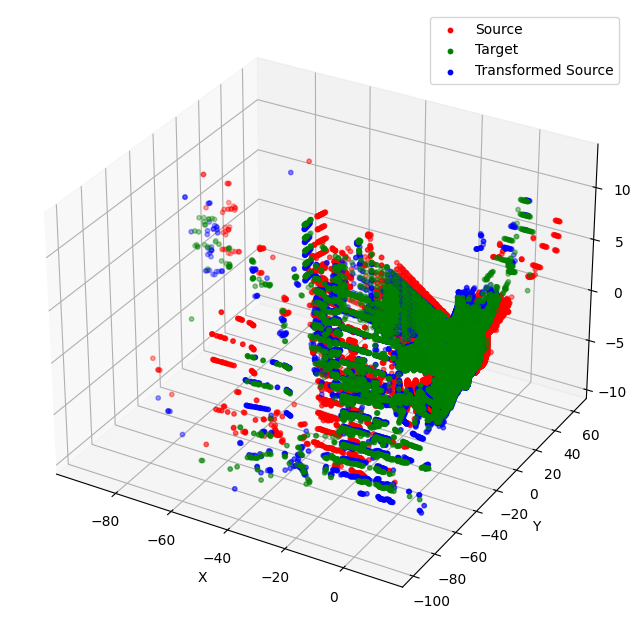

In [ ]:
reference_path = "./1/0/output.pcd"
target_path = "./1/1/output.pcd"

# Load point clouds
reference_cloud = load_point_cloud(reference_path)
target_cloud = load_point_cloud(target_path)

# get the transformation matrix
transformation = align_point_clouds(reference_cloud, target_cloud)

# Specify the output folder
output_folder = "../output/gt_legoloam"

# Extract subfolder information from the target path
subfolder = os.path.dirname(target_path).replace("gt_legoloam/", "")

# Write the transformation matrix to the output folder
write_transformation_to_file(transformation, output_folder, subfolder)

# Visualize the aligned point clouds
visualize_point_clouds(reference_cloud, target_cloud, transformation)

-------
## Additional Notes and Methods

By running the above code, the transformation matrix is written to the output folder and the aligned point clouds are visualized. The transformation matrix is written to a file named pose.txt in the output folder. The visualization shows the source (red) and target (green) point clouds, as well as the transformed source (blue) point cloud after applying the estimated transformation matrix.

The next part is my idea of modifying the cuPCL code to work with the given input and output folders.

The original methods in [cuPCL/cuICP/main.cpp](https://github.com/NVIDIA-AI-IOT/cuPCL/blob/main/cuICP/main.cpp) can be modified to take specific input and output file path as arguments, which facilitates us to call the c++ executable from python and process the entire dataset. Also in the original method the transformation matrix will be printed to the console, and we can use python pipe to capture the output and write it to a text file as requested.



![sc](https://github.com/fy916/USCiLab-supporting-code/blob/main/screenshots/1.jpg?raw=true)
![sc](https://github.com/fy916/USCiLab-supporting-code/blob/main/screenshots/2.jpg?raw=true)



In [ ]:
! g++ ../main.cpp -o ../main

In [ ]:
# use the following python code to call the c++ executable and capture the output and store in the txt file

import subprocess
import os

cpp_executable = '../main'
folder_path = r'/'

reference_path = "./1/0/output.pcd"
target_path = "./1/1/output.pcd"

arg1 = reference_path
arg2 = target_path

# Run the C++ executable with two path arguments and capture the output
process = subprocess.Popen([cpp_executable, folder_path, arg1, arg2], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
stdout, stderr = process.communicate()

# Check if the process was successful
if process.returncode == 0:
    print("C++ program executed successfully.")

    # Specify the output folder
    output_folder = "../output/gt_legoloam"

    # Extract subfolder information from the target path
    subfolder = os.path.dirname(target_path).replace("gt_legoloam/", "")
    os.makedirs(os.path.join(output_folder, subfolder), exist_ok=True)
    output_path = os.path.join(output_folder, subfolder, 'pose_cpp.txt')

    full_path = os.path.abspath(output_path)
    print("Transformation matrix saved to", full_path)

    with open(output_path, 'w') as output_file:
        output_file.write(stdout.decode())
        print(stdout.decode())
else:
    print(f"Error running C++ program. Error message:\n{stderr.decode()}")

C++ program executed successfully.
Transformation matrix saved to /content/drive/MyDrive/Feiyang_Wang_ICP_Solution/USCilab3D/data/output/gt_legoloam/1/1/pose_cpp.txt
reference_path: ./1/0/output.pcd
target_path: ./1/1/output.pcd

Because Colab could not load the cuPCL due to CUDA issue with the shell command,
this cpp file is used as a placeholder to test if the colab code works.

The original code from https://github.com/NVIDIA-AI-IOT/cuPCL/blob/main/cuICP/main.cpp
will work on local machines configured with CUDA environment.

Running the code in local machine with adjustment as mentioned above, 
the transformation matrix will be stored in the corresponding output file. 



# The last block is the additional method using cuPCL/cuICP/main.cpp which could not run on Colab due to CUDA environment issues, but it can work on local machines. For the final transformation matrix generated by open3d, please see the above blocks with the title "Show Results".